# start

from 0320_1; now max_delta_step on

In [1]:
PRFX='0320_2'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

In [2]:
grand_total=1.5e8

# setup

In [3]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [4]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [5]:
def prp_df(df, istrn=True):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'twtid', 'u1id', 'u2id']+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',])        
    return df

In [6]:
grand_total

150000000.0

In [7]:
grand_total/1e6

150.0

In [8]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-20 15:14:27 chunk 0


In [9]:
df = pd.concat(lst_df)

In [10]:
df.shape

(1000000, 97)

In [11]:
df.columns

Index(['tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed', 'u1_create_tm',
       'u2_follower_cnt', 'u2_following_cnt', 'u2_vrfed', 'u2_create_tm',
       'u1_fllw_u2', 'len_toks', 'has_media_Photo', 'has_media_Video',
       'has_media_GIF', 'num_hshtgs', 'num_links', 'num_domns', 'tm_month',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D6

In [12]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [13]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 311 ms, sys: 292 ms, total: 604 ms
Wall time: 603 ms


In [14]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((850000, 93), (150000, 93), (850000, 4), (150000, 4))

# model

In [15]:
params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
#     https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    'max_delta_step': 1,
}
num_rounds = 800


In [16]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 15:14:37 Retweet ********************************************************************************
[15:14:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11047	train-logloss:0.58776	eval-error:0.11123	eval-logloss:0.58783
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[15:14:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.11008	train-logloss:0.50370	eval-error:0.11119	eval-logloss:0.50422
[15:14:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.10996	train-logloss:0.44023	eval-error:0.11098	eval-logloss:0.44080
[15:14:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6


[15:15:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.10848	train-logloss:0.30707	eval-error:0.11021	eval-logloss:0.31192
[15:15:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.10848	train-logloss:0.30697	eval-error:0.11021	eval-logloss:0.31191
[15:15:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.10845	train-logloss:0.30684	eval-error:0.11021	eval-logloss:0.31188
[15:15:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.10845	train-logloss:0.30680	eval-error:0.11021	eval-logloss:0.31187
[15:15:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.10839	train-logloss:0.30665	eva

[15:15:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.10776	train-logloss:0.30241	eval-error:0.10991	eval-logloss:0.31013
[15:15:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.10772	train-logloss:0.30230	eval-error:0.10989	eval-logloss:0.31013
[15:15:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.10771	train-logloss:0.30224	eval-error:0.10988	eval-logloss:0.31012
[15:15:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.10771	train-logloss:0.30217	eval-error:0.10988	eval-logloss:0.31013
[15:15:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.10770	train-logloss:0.30201	ev

[15:16:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-error:0.10710	train-logloss:0.29887	eval-error:0.10987	eval-logloss:0.30993
[15:16:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.10708	train-logloss:0.29877	eval-error:0.10990	eval-logloss:0.30992
[15:16:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.10707	train-logloss:0.29870	eval-error:0.10991	eval-logloss:0.30995
Stopping. Best iteration:
[111]	train-error:0.10719	train-logloss:0.29963	eval-error:0.10985	eval-logloss:0.30985

2020-03-20 15:16:21 Reply ********************************************************************************
[15:16:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-error:0.02778	train-logl

[15:16:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-error:0.02775	train-logloss:0.10996	eval-error:0.02715	eval-logloss:0.11157
[15:16:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[36]	train-error:0.02775	train-logloss:0.10987	eval-error:0.02716	eval-logloss:0.11156
[15:16:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[37]	train-error:0.02775	train-logloss:0.10977	eval-error:0.02716	eval-logloss:0.11158
[15:16:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[38]	train-error:0.02775	train-logloss:0.10972	eval-error:0.02716	eval-logloss:0.11157
[15:16:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.02775	train-logloss:0.10966	eva

Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[15:17:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.34977	train-logloss:0.64548	eval-error:0.35145	eval-logloss:0.64627
[15:17:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.34615	train-logloss:0.63449	eval-error:0.34813	eval-logloss:0.63569
[15:17:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-error:0.34214	train-logloss:0.62718	eval-error:0.34384	eval-logloss:0.62852
[15:17:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-error:0.34125	train-logloss:0.62287	eval-error:0.34303	eval-logloss:0.62441
[15:17:35] INFO: /works

[15:17:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.31644	train-logloss:0.59228	eval-error:0.32249	eval-logloss:0.59828
[15:17:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.31605	train-logloss:0.59185	eval-error:0.32257	eval-logloss:0.59796
[15:18:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.31573	train-logloss:0.59153	eval-error:0.32219	eval-logloss:0.59774
[15:18:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.31558	train-logloss:0.59127	eval-error:0.32199	eval-logloss:0.59766
[15:18:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[44]	train-error:0.31547	train-logloss:0.59110	

[15:18:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.30858	train-logloss:0.58279	eval-error:0.31819	eval-logloss:0.59247
[15:18:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.30844	train-logloss:0.58256	eval-error:0.31808	eval-logloss:0.59226
[15:18:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.30829	train-logloss:0.58237	eval-error:0.31803	eval-logloss:0.59218
[15:18:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.30822	train-logloss:0.58226	eval-error:0.31802	eval-logloss:0.59215
[15:18:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[84]	train-error:0.30812	train-logloss:0.58209	eva

[15:18:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.30368	train-logloss:0.57671	eval-error:0.31541	eval-logloss:0.58937
[15:18:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.30357	train-logloss:0.57654	eval-error:0.31529	eval-logloss:0.58926
[15:18:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-error:0.30354	train-logloss:0.57644	eval-error:0.31522	eval-logloss:0.58917
[15:18:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[123]	train-error:0.30348	train-logloss:0.57638	eval-error:0.31524	eval-logloss:0.58918
[15:18:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[124]	train-error:0.30338	train-logloss:0.576

[15:19:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[160]	train-error:0.30029	train-logloss:0.57249	eval-error:0.31421	eval-logloss:0.58775
[15:19:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[161]	train-error:0.30017	train-logloss:0.57233	eval-error:0.31409	eval-logloss:0.58761
[15:19:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[162]	train-error:0.30013	train-logloss:0.57227	eval-error:0.31415	eval-logloss:0.58762
[15:19:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[163]	train-error:0.30012	train-logloss:0.57225	eval-error:0.31415	eval-logloss:0.58761
[15:19:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[164]	train-error:0.30007	train-logloss:0.57220	

[15:19:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[200]	train-error:0.29582	train-logloss:0.56741	eval-error:0.31207	eval-logloss:0.58508
[15:19:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[201]	train-error:0.29577	train-logloss:0.56732	eval-error:0.31209	eval-logloss:0.58506
[15:19:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[202]	train-error:0.29572	train-logloss:0.56725	eval-error:0.31215	eval-logloss:0.58505
[15:19:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[203]	train-error:0.29565	train-logloss:0.56714	eval-error:0.31213	eval-logloss:0.58502
[15:19:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[204]	train-error:0.29552	train-logloss:0.566

[15:20:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[240]	train-error:0.29284	train-logloss:0.56354	eval-error:0.31090	eval-logloss:0.58379
[15:20:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[241]	train-error:0.29283	train-logloss:0.56353	eval-error:0.31093	eval-logloss:0.58380
[15:20:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[242]	train-error:0.29280	train-logloss:0.56349	eval-error:0.31087	eval-logloss:0.58378
[15:20:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[243]	train-error:0.29280	train-logloss:0.56347	eval-error:0.31089	eval-logloss:0.58379
[15:20:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[244]	train-error:0.29278	train-logloss:0.56344	

[15:20:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.00777	train-logloss:0.04179	eval-error:0.00759	eval-logloss:0.04267
[15:20:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[33]	train-error:0.00777	train-logloss:0.04172	eval-error:0.00759	eval-logloss:0.04265
[15:20:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-error:0.00777	train-logloss:0.04166	eval-error:0.00759	eval-logloss:0.04265
[15:20:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-error:0.00777	train-logloss:0.04158	eval-error:0.00759	eval-logloss:0.04264
[15:20:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[36]	train-error:0.00777	train-logloss:0.04156	eval

In [17]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


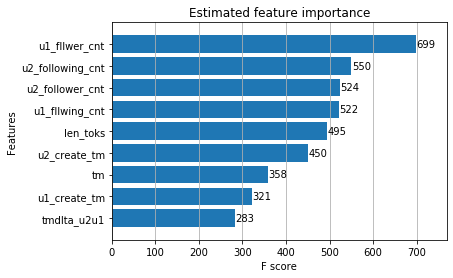

,0,1
6,u1_fllwer_cnt,699
1,u2_following_cnt,550
7,u2_follower_cnt,524
5,u1_fllwing_cnt,522
2,len_toks,495
4,u2_create_tm,450
14,tm,358
13,u1_create_tm,321
12,tmdlta_u2u1,283
10,tmdlta_twtu1,223


Reply


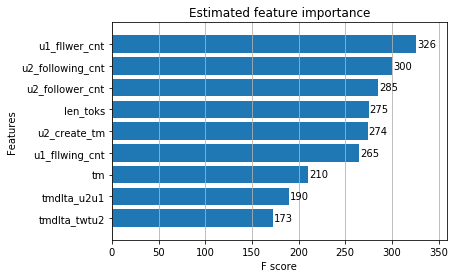

,0,1
7,u1_fllwer_cnt,326
2,u2_following_cnt,300
8,u2_follower_cnt,285
4,len_toks,275
12,u2_create_tm,274
10,u1_fllwing_cnt,265
11,tm,210
0,tmdlta_u2u1,190
1,tmdlta_twtu2,173
15,tm_hour,135


Like


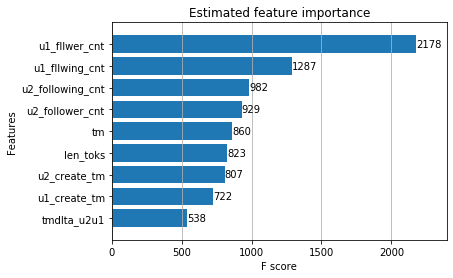

,0,1
5,u1_fllwer_cnt,2178
21,u1_fllwing_cnt,1287
9,u2_following_cnt,982
6,u2_follower_cnt,929
15,tm,860
2,len_toks,823
3,u2_create_tm,807
7,u1_create_tm,722
12,tmdlta_u2u1,538
13,tmdlta_twtu1,535


RTwCmnt


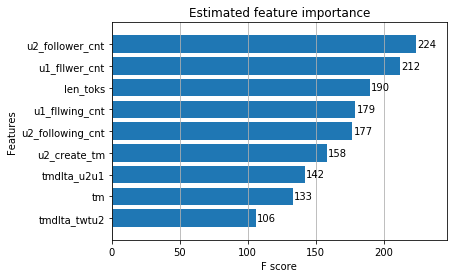

,0,1
1,u2_follower_cnt,224
3,u1_fllwer_cnt,212
5,len_toks,190
9,u1_fllwing_cnt,179
2,u2_following_cnt,177
0,u2_create_tm,158
4,tmdlta_u2u1,142
11,tm,133
10,tmdlta_twtu2,106
7,u1_create_tm,97


In [18]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

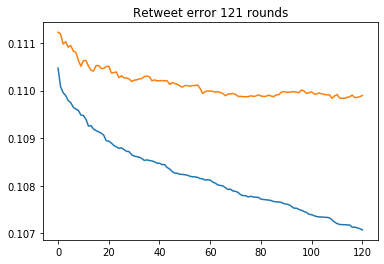

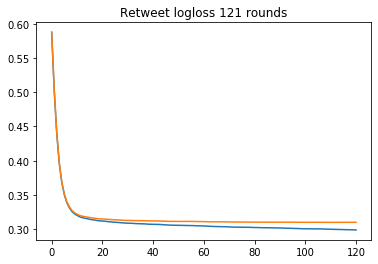

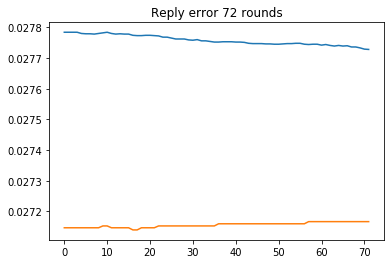

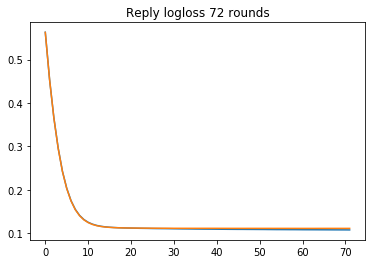

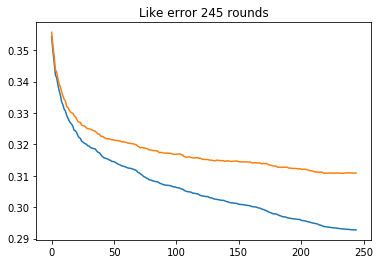

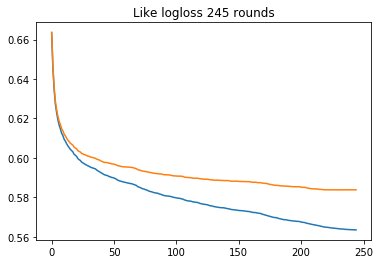

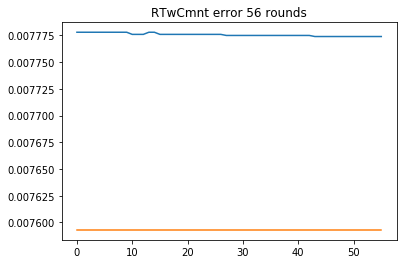

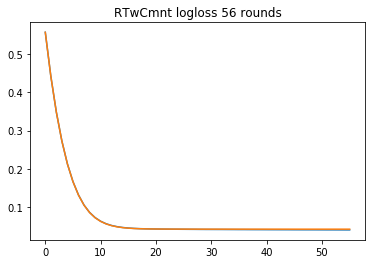

In [19]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [20]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 15:21:03 Retweet
2020-03-20 15:21:03 Reply
2020-03-20 15:21:04 Like
2020-03-20 15:21:05 RTwCmnt


In [ ]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7713 valid auc: 0.7442
train prauc: 0.3626 valid auc: 0.3168
train rce: 15.3546 valid rce: 12.3840
Reply
train rocauc: 0.8096 valid auc: 0.7713
train prauc: 0.1513 valid auc: 0.0907
train rce: 15.0532 valid rce: 10.6227
Like
train rocauc: 0.7739 valid auc: 0.7493
train prauc: 0.7271 valid auc: 0.6957
train rce: 17.8483 valid rce: 14.8018
RTwCmnt


In [ ]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

# infer

In [65]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 38s, sys: 8.77 s, total: 1min 46s
Wall time: 1min 47s


In [66]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 56s, sys: 9.91 s, total: 2min 6s
Wall time: 2min 6s


In [67]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 14:35:37 Retweet
2020-03-20 14:35:44 Reply
2020-03-20 14:35:50 Like
2020-03-20 14:36:29 RTwCmnt
CPU times: user 15min 29s, sys: 35.8 s, total: 16min 5s
Wall time: 3min 3s


In [68]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [69]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 14:36:34 Retweet
2020-03-20 14:37:33 Reply
2020-03-20 14:38:33 Like
2020-03-20 14:39:32 RTwCmnt
CPU times: user 3min 49s, sys: 6.79 s, total: 3min 56s
Wall time: 3min 56s
